<span><h1 style="color:#4987FF">
Speed-Optimisation for Scientific Python
</h1></span>

# Target Audience:

### People with -
* Working knowledge of python and common maths/science libraries (numpy, scipy)

* A functioning Python3 installation. (Python 2 should also be fine but may require minor changes to some parts of the code)

* Ability to install the following modules/libraries

> "pip install timeit"

> "pip install cython" <- not needed with Anaconda

> "pip install py-heat-magic"

> "pip install line_profiler"

> "pip install numba"

* (preferably) experience with Jupyter Notebooks. (Some differences in some techniques if replicated on the REPL or in a script)

In [1]:
%load_ext heat
import timeit
import numpy as np

<span><h1 style="color:#4987FF">
Example 1: Collecting Primes
</h1></span>

### Showing how to choose where to optimise, 
### Comparison between operations on numpy arrays and lists

In [6]:
big_number = 5000

"""
1: baseline result
"""
is_prime=lambda x: all(x % i != 0 for i in range(int(x))[2:])

"""
2: More carefully written is_prime() - only checks factors 2, and odd nums up to sqrt(big_number)
Makes list of possible factors *once* at the start and then uses that rather than reevaluating every time it's called
"""
#possible_factors = [i for i in range(int(big_number**0.5)+1)[2:][1::2]]
#possible_factors.insert(0,2)
#is_prime=lambda x: all(x % i != 0 for i in possible_factors)

# Primes in first "big_number" integers using a numpy array inefficiently:
def bad_np():
    global big_number
    primes = np.array([])
    for i in range(big_number):
        if is_prime(i):
            primes = np.append(primes,i)
    return primes

# same, but using a list instead of a numpy array:
def normal_list():
    global big_number
    primes = []
    for i in range(big_number):
        if is_prime(i):
            primes.append(i)
    return primes

# using a numpy array in a (seemingly) more efficient way:
def other_np():
    global big_number
    one_to_10k = np.linspace(0,big_number,big_number+1)
    np_is_prime_func = np.vectorize(is_prime)
    arr_is_prime = np_is_prime_func(one_to_10k)
    return one_to_10k[np.where(arr_is_prime)]

# using a list comprehension:
def better_list():
    global big_number
    return [num for num in range(big_number) if is_prime(num)]

# here we take parts of the list and np ones previously and investigate combining them
def mix_list_np():
    global big_number
    np_is_prime_func = np.vectorize(is_prime)
    one_to_10k = range(big_number)
    arr_is_prme = np_is_prime_func(one_to_10k)
    return [num for num in one_to_10k if arr_is_prme[num]]

In [7]:
print("bad_np method:")
%timeit -n1 -r1 bad_np()
print('\n\nnormal_list method:')
%timeit -n1 -r1 normal_list()
print('\n\nother_np method:')
%timeit -n1 -r1 other_np()
print('\n\nbetter_list method:')
%timeit -n1 -r1 better_list()
print('\n\nmix_list_np method:')
%timeit -n1 -r1 mix_list_np()


bad_np method:
1 loop, best of 1: 976 ms per loop


normal_list method:
1 loop, best of 1: 874 ms per loop


other_np method:
1 loop, best of 1: 1.17 s per loop


better_list method:
1 loop, best of 1: 1.09 s per loop


mix_list_np method:
1 loop, best of 1: 916 ms per loop


### And here we see we've basically wasted our time;
* There were some minimal differences between the results, worth the improvements only if this is going to be used often and for large numbers.

* Let's take a look at what parts of the code are taking the most time:

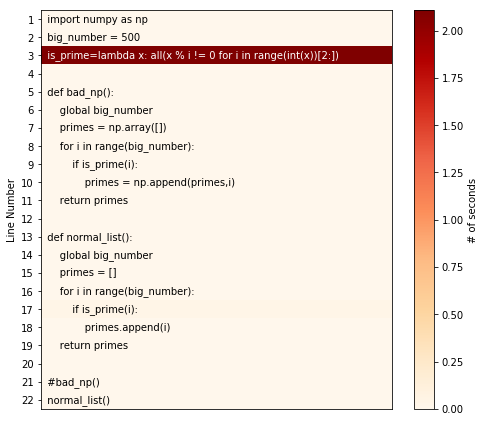

In [5]:
%%heat
import numpy as np
big_number = 500
is_prime=lambda x: all(x % i != 0 for i in range(int(x))[2:])

def bad_np():
    global big_number
    primes = np.array([])
    for i in range(big_number):
        if is_prime(i):
            primes = np.append(primes,i)
    return primes

def normal_list():
    global big_number
    primes = []
    for i in range(big_number):
        if is_prime(i):
            primes.append(i)
    return primes

#bad_np()
normal_list()

So we can see clearly that we were optimising the wrong part of the code! 

The actual structure of the functions has a near-negligible effect on the time taken, 
as it spends almost all of the run time evaluating is_prime() 

We now go back to cell 5 and switch to a more carefully written is_prime(), to confirm that writing it even slightly more efficiently leads to a reasonable increase in speed:

__(scroll up, comment out current is_prime, uncomment the other one)__